<a href="https://colab.research.google.com/github/WilliamMejiaG/Packed_Bed_Membrane_Reactor_Simulation/blob/main/PBMR_Cocurrent_configuration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy import optimize
import pandas as pd


In [ ]:
def F_CO(VF,D_i,D_o,D_shell,FACT,rho_B,i,j,k,l,m):
    ####################################################################
    #Inlet molar fluxes
    R=8.314472 #J/mol K
    Ar = (np.pi*(D_i**2))/4 #m2
    Dm = (D_o-D_i)/np.log(D_o/D_i)
    Pm = np.pi*Dm
    VSweep = l*VF
    VCO2_0 = VF/(m+1)
    VH2_0 = m*VCO2_0
    nH2_0 = VH2_0/(22400*60) #V in cm3 STP/min
    nCO2_0 = VCO2_0/(22400*60) #V in cm3 STP/min
    nSweep = VSweep/(22400*60) #V in cm3 STP/min
    T = j+273
    
    """
    PACKED BED MEMBRANE REACTOR MODEL
    """
    # ODE definition
    def F(y,X):
        F = np.zeros(11)
        """
        RETENTATE SIDE
        """
        #Molar fluxes retentate
    
        n_H2r = y[0] 
        n_CO2r = y[1] 
        n_MeOHr = y[2]
        n_COr = y[3]
        n_Wr = y[4]
   
        n_Tr = n_H2r+n_CO2r+n_MeOHr+n_COr+n_Wr
    
        TERM = (i/(n_Tr)) 
    
        pH2 = TERM*n_H2r
        pCO2 = TERM*n_CO2r
        pMeOH = TERM*n_MeOHr
        pCO = TERM*n_COr
        pW = TERM*n_Wr

        """
        PERMEATE SIDE
        """
        
        Perm_W = 2.48e-3 #mol/ m2 s bar
        Perm_MeOH =  1.77e-4 #mol/ m2 s bar
        Perm_H2 = 1.38e-5 #mol/ m2 s bar
        Perm_CO2 = 1.38e-5
        #Perm_CO2 = 0
        Perm_CO = 1.38e-5
    
        #Molar fluxes permeate

        n_H2p = y[5] 
        n_CO2p = y[6] 
        n_MeOHp = y[7]
        n_COp = y[8]
        n_Wp = y[9]
        n_swp = y[10]
        n_Tp = n_H2p+n_CO2p+n_MeOHp+n_COp+n_Wp+n_swp
    
        Pp = FACT*i#bar
    
        #Molar fractions Permeate
        y_H2p = n_H2p/n_Tp
        y_CO2p = n_CO2p/n_Tp
        y_MeOHp = n_MeOHp/n_Tp
        y_COp = n_COp/n_Tp
        y_Wp = n_Wp/n_Tp
   
    
        #Partial pressures permeate

        pH2_p = y_H2p*Pp #bar
        pCO2_p = y_CO2p*Pp #bar
        pMeOH_p = y_MeOHp*Pp  #bar
        pCO_p = y_COp*Pp #bar
        pW_p = y_Wp*Pp  #bar
   
        """
        KINETICS
        """
        #Equilibrium constants
        K1 = 10**((3066/T)-10.592)
        K3 = 1/(10**((-2073.00/T)+2.029)) 
        #Parameters
    
        A = 1.07*np.exp(36696.00/(R*T)) #N0 mol/ kg cat s bar^2, Q J/mol
        C = 1.22e10*np.exp(-94765.00/(R*T)) # N0 mol/ kg cat s bar, Q J/mol
        D = 3453.38
        E = 0.499*np.exp(17197.00/(R*T)) # N0 bar^-0.5, Q J/mol
        N = 6.62e-11*np.exp(124119.00/(R*T)) # N0 bar^-1, Q J/mol
    
        #Reaction Equations
        B = 1 + D*(pW/pH2) + E*np.sqrt(pH2) + N*pW
        r1 = (A*pCO2*pH2*(1-((pW*pMeOH)/(K1*(pH2**3)*pCO2))))/(B**3)
        r3 = (C*pCO2*(1-((K3*pW*pCO)/(pH2*pCO2))))/B
    
        """
        Differential equations retentate
        """
        F[0] = -Pm*Perm_H2*(pH2-pH2_p)+Ar*(-3*r1-r3)*(rho_B)
        F[1] = -Pm*Perm_CO2*(pCO2-pCO2_p)+Ar*(-r1-r3)*(rho_B)
        F[2] = -Pm*Perm_MeOH*(pMeOH-pMeOH_p)+Ar*(r1)*(rho_B)
        F[3] = -Pm*Perm_CO*(pCO-pCO_p)+(r3)*Ar*(rho_B)
        F[4] = -Pm*Perm_W*(pW-pW_p)+(r1+r3)*Ar*(rho_B)
    
    
        """
        Differential equations permeate co-current mode
        """
        F[5] = Pm*Perm_H2*(pH2-pH2_p)
        F[6] = Pm*Perm_CO2*(pCO2-pCO2_p)
        F[7] = Pm*Perm_MeOH*(pMeOH-pMeOH_p)
        F[8] = Pm*Perm_CO*(pCO-pCO_p)
        F[9] = Pm*Perm_W*(pW-pW_p)
        F[10] = 0

        return F
    # Initial conditions
    
    y = np.array([nH2_0,nCO2_0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nSweep])
    
    xStart = 0.0
    h = 1.0e-5
    k = k+h
    X = np.arange(xStart,k,h,dtype=float)
    Y = odeint(F,y,X)
    
    #FOR FROMENT CO-CURRENT FUNCTION
    n_H2r = Y[:,0]
    n_CO2r = Y[:,1]
    n_MeOHr = Y[:,2]
    n_COr = Y[:,3]
    n_Wr = Y[:,4]
    n_H2p = Y[:,5]
    n_CO2p = Y[:,6]
    n_MeOHp = Y[:,7]
    n_COp = Y[:,8]
    n_Wp = Y[:,9]
    n_swp = Y[:,10]

    n_Tr = n_H2r+n_CO2r+n_MeOHr+n_COr+n_Wr
    n_Tp = n_H2p+n_CO2p+n_MeOHp+n_COp+n_Wp+n_swp
    
    pH2r = (n_H2r/n_Tr)*i
    pCO2r = (n_CO2r/n_Tr)*i
    pMeOHr = (n_MeOHr/n_Tr)*i
    pCOr = (n_COr/n_Tr)*i
    pWr = (n_Wr/n_Tr)*i
    
    pH2p = (n_H2p/n_Tp)*i
    pCO2p = (n_CO2p/n_Tp)*i
    pMeOHp = (n_MeOHp/n_Tp)*i
    pCOp = (n_COp/n_Tp)*i
    pWp = (n_Wp/n_Tp)*i
              
    #Graphic for conversion
        
    X_CO2 = ((nCO2_0-(n_CO2r+n_CO2p))/nCO2_0)*100      
    S_MeOH = ((n_MeOHr+n_MeOHp)/(nCO2_0-n_CO2r))*100
    Y_MeOH = (X_CO2*S_MeOH)/100
    
    
    
    
    FROMENT = "FROMENT"
    CO_CURRENT = "CO_CURRENT"
         
    return X,X_CO2,S_MeOH,Y_MeOH,n_H2r,n_CO2r,n_MeOHr,n_COr,n_Wr,n_H2p,n_CO2p,n_MeOHp,n_COp,n_Wp,n_swp,pH2r,pCO2r,pMeOHr,pCOr,pWr,pH2p,pCO2p,pMeOHp,pCOp,pWp,CO_CURRENT,FROMENT

In [ ]:
i = 10
j = 250
k = 0.10
VF = 250
l = 1
m = 3
D_i = 0.009 #m
D_o = 0.012 #m
D_shell = 0.019#m
FACT = 1
rho_B= 1142 #kg cat/m3 lecho


In [ ]:
X,X_CO2,S_MeOH,Y_MeOH,n_H2r,n_CO2r,n_MeOHr,n_COr,n_Wr,n_H2p,n_CO2p,n_MeOHp,n_COp,n_Wp,n_swp,pH2r,pCO2r,pMeOHr,pCOr,pWr,pH2p,pCO2p,pMeOHp,pCOp,pWp,CO_CURRENT,FROMENT = F_CO(VF,D_i,D_o,D_shell,FACT,rho_B,i,j,k,l,m)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
data = np.array([X,X_CO2,S_MeOH,Y_MeOH,n_H2r,n_CO2r,n_MeOHr,n_COr,n_Wr,n_H2p,n_CO2p,n_MeOHp,n_COp,n_Wp,n_swp,pH2r,pCO2r,pMeOHr,pCOr,pWr,pH2p,pCO2p,pMeOHp,pCOp,pWp])
data_transposed = data.transpose()
df_PBMR_CO = pd.DataFrame(data_transposed,columns=["Reactor_Length","Conversion",'Selectivity','Yield','n_H2r','n_CO2r','n_MeOHr','n_COr','n_Wr','n_H2p','n_CO2p','n_MeOHp','n_COp','n_Wp','n_swp','pH2r','pCO2r','pMeOHr','pCOr','pWr','pH2p','pCO2p','pMeOHp','pCOp','pWp'])
df_PBMR_CO

,Reactor_Length,Conversion,Selectivity,Yield,n_H2r,n_CO2r,n_MeOHr,n_COr,n_Wr,n_H2p,n_CO2p,n_MeOHp,n_COp,n_Wp,n_swp,pH2r,pCO2r,pMeOHr,pCOr,pWr,pH2p,pCO2p,pMeOHp,pCOp,pWp
0,0.00000,0.000000,NaN,NaN,0.000140,0.000047,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000186,7.500000,2.500000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.00001,0.538379,60.336874,0.324841,0.000139,0.000046,1.510672e-07,9.929462e-08,2.503565e-07,3.386704e-11,1.128087e-11,2.434411e-13,1.221381e-14,5.605681e-12,0.000186,7.482452,2.490586,0.008135,0.005347,0.013481,0.000002,6.064594e-07,1.308739e-08,6.566142e-10,3.013613e-07
2,0.00002,0.972301,58.138474,0.565281,0.000139,0.000046,2.628847e-07,1.892633e-07,4.521279e-07,6.766339e-11,2.252283e-11,8.943863e-13,4.744966e-14,2.105743e-11,0.000186,7.468538,2.482710,0.014173,0.010204,0.024375,0.000004,1.210827e-06,4.808218e-08,2.550892e-09,1.132047e-06
3,0.00003,1.342550,56.313181,0.756032,0.000138,0.000046,3.515947e-07,2.727289e-07,6.242809e-07,1.014026e-10,3.373172e-11,1.853507e-12,1.037380e-13,4.460877e-11,0.000186,7.456824,2.475796,0.018973,0.014718,0.033689,0.000005,1.813416e-06,9.964446e-08,5.576947e-09,2.398165e-06
4,0.00004,1.667167,54.713605,0.912167,0.000138,0.000046,4.242064e-07,3.510726e-07,7.752069e-07,1.350922e-10,4.491083e-11,3.067774e-12,1.798642e-13,7.529787e-11,0.000186,7.446678,2.469586,0.022910,0.018960,0.041866,0.000007,2.414403e-06,1.649233e-07,9.669488e-09,4.048008e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.09996,19.651884,7.557884,1.485267,0.000129,0.000037,6.769777e-07,8.421749e-06,6.589564e-06,3.193990e-07,9.367406e-08,2.079524e-08,1.918840e-08,2.549146e-06,0.000186,7.083989,2.052185,0.037276,0.463717,0.362833,0.016898,4.955929e-03,1.100195e-03,1.015183e-03,1.348654e-01
9997,0.09997,19.652090,7.557899,1.485285,0.000129,0.000037,6.769849e-07,8.421834e-06,6.589475e-06,3.194309e-07,9.368331e-08,2.079734e-08,1.919049e-08,2.549332e-06,0.000186,7.083991,2.052182,0.037276,0.463722,0.362829,0.016900,4.956413e-03,1.100305e-03,1.015293e-03,1.348751e-01
9998,0.09998,19.652297,7.557914,1.485304,0.000129,0.000037,6.769922e-07,8.421919e-06,6.589386e-06,3.194629e-07,9.369257e-08,2.079944e-08,1.919258e-08,2.549517e-06,0.000186,7.083993,2.052179,0.037277,0.463727,0.362824,0.016901,4.956897e-03,1.100414e-03,1.015402e-03,1.348847e-01
9999,0.09999,19.652503,7.557928,1.485322,0.000129,0.000037,6.769994e-07,8.422003e-06,6.589296e-06,3.194948e-07,9.370182e-08,2.080153e-08,1.919467e-08,2.549703e-06,0.000186,7.083994,2.052176,0.037277,0.463732,0.362820,0.016903,4.957380e-03,1.100524e-03,1.015512e-03,1.348943e-01


In [ ]:
#To export your data frame to Excel
df_PBMR_CO.to_excel('PBMR_CO_10_250.xlsx',index=False,header=False) 
from google.colab import files
files.download('PBMR_CO_10_250.xlsx')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

19.652709602270342
[        nan 60.33687373 58.13847362 ...  7.55791361  7.55792818
  7.55794275]
1.4853405411739389


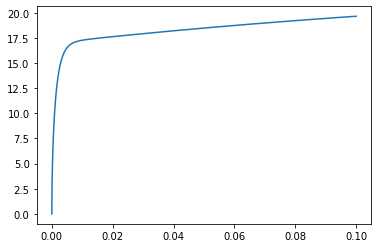

In [ ]:
plt.plot(X,X_CO2);
print(X_CO2[-1])
print(S_MeOH)
print(Y_MeOH[-1])

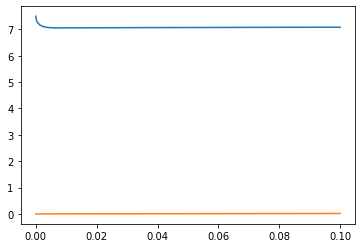

In [ ]:
plt.plot(X,pH2r, color = '#1f77b4');
plt.plot(X,pH2p, color = '#ff7f0e');

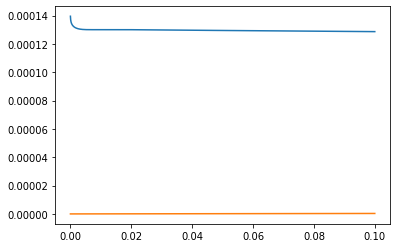

In [ ]:
plt.plot(X,n_H2r, color = '#1f77b4');
plt.plot(X,n_H2p, color = '#ff7f0e');

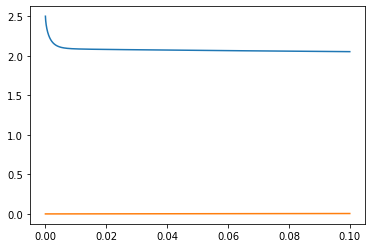

In [ ]:
plt.plot(X,pCO2r);
plt.plot(X,pCO2p);

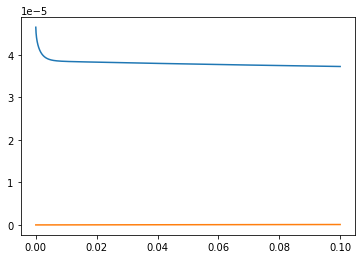

In [ ]:
plt.plot(X,n_CO2r, color = '#1f77b4');
plt.plot(X,n_CO2p, color = '#ff7f0e');

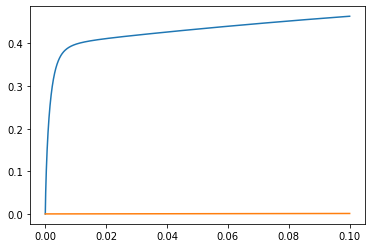

In [ ]:
plt.plot(X,pCOr);
plt.plot(X,pCOp);

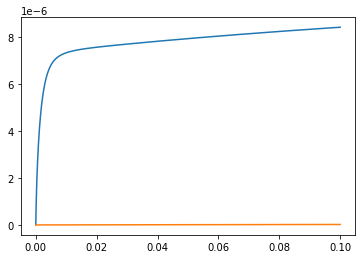

In [ ]:
plt.plot(X,n_COr);
plt.plot(X,n_COp);

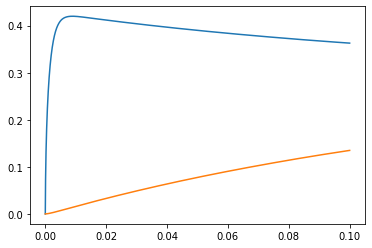

In [ ]:
plt.plot(X,pWr);
plt.plot(X,pWp);

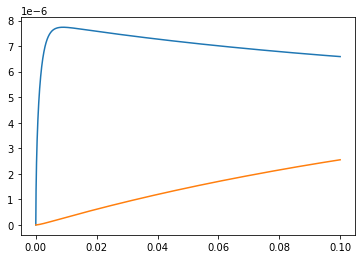

In [ ]:
plt.plot(X,n_Wr);
plt.plot(X,n_Wp);

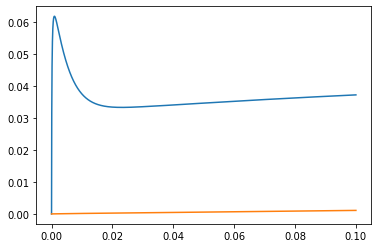

In [ ]:
plt.plot(X,pMeOHr);
plt.plot(X,pMeOHp);

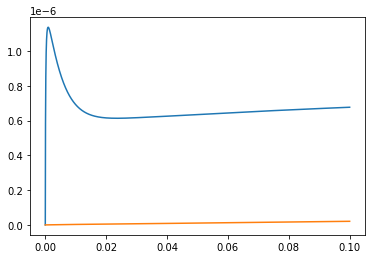

In [ ]:
plt.plot(X,n_MeOHr);
plt.plot(X,n_MeOHp);

0.00018601190476190475
0.00018601190476190475
0.00018901503110436887
0.00018161315804365334


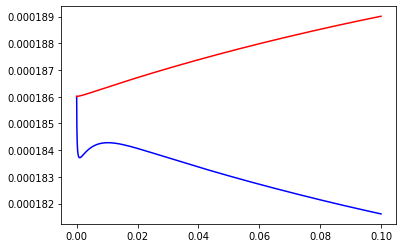

In [ ]:
nTr = n_H2r+n_CO2r+n_MeOHr+n_COr+n_Wr
nTp = n_H2p+n_CO2p+n_MeOHp+n_COp+n_Wp+n_swp
plt.plot(X,nTr, color='blue');
plt.plot(X,nTp, color='red');

print(nTp[0])
print(nTr[0])
print(nTp[-1])
print(nTr[-1])

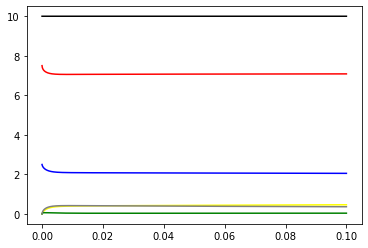

In [ ]:
ppr = pCO2r+pH2r+pMeOHr+pCOr+pWr
plt.plot(X,ppr, color = 'black');
plt.plot(X,pH2r, color = 'red');
plt.plot(X,pCO2r, color = 'blue');
plt.plot(X,pCOr, color = 'yellow');
plt.plot(X,pMeOHr, color = 'green');
plt.plot(X,pWr, color = 'gray');

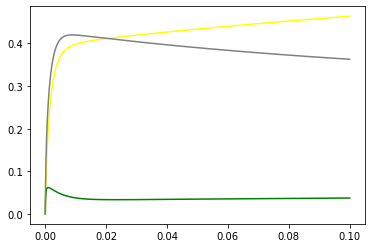

In [ ]:
plt.plot(X,pCOr, color = 'yellow');
plt.plot(X,pMeOHr, color = 'green');
plt.plot(X,pWr, color = 'gray');

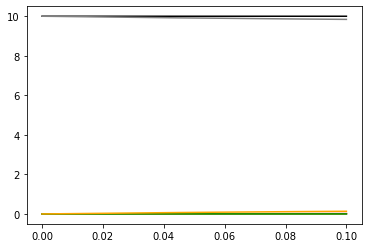

In [ ]:
pswep = (n_swp/nTp)*i
ppp = pCO2p+pH2p+pMeOHp+pCOp+pWp+pswep
plt.plot(X,ppp, color = 'black');
plt.plot(X,pH2p, color = 'red');
plt.plot(X,pCO2p, color = 'blue');
plt.plot(X,pCOp, color = 'yellow');
plt.plot(X,pMeOHp, color = 'green');
plt.plot(X,pWp, color = 'orange');
plt.plot(X,pswep, color = 'gray');

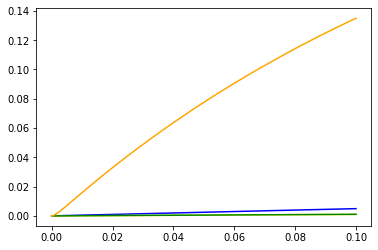

In [ ]:
plt.plot(X,pCO2p, color = 'blue');
plt.plot(X,pCOp, color = 'yellow');
plt.plot(X,pMeOHp, color = 'green');
plt.plot(X,pWp, color = 'orange');